## Pre main imports and exports

Just the imports, consts and exports of env

In [12]:
import numpy as np
import pandas as pd
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Const Parameters

BATCH_SIZE = 8
LEARNING_RATE = 0.005
MOMENTUM = 0.3
SEED = 123
LOSS = 'mape'
COLS_TO_DROP = ['Umsatz']
INPUT_PATH = './10_test.csv'
OUTPUT_PATH = './model.keras'
EPOCHS = 25

## Importing the Data

Import data from given path, the model.py script works with args, here we hardcode the paths and the epochs.

In [2]:
# import data
data = pd.read_csv(INPUT_PATH)


    # split data into features and target
features = data.drop(columns=COLS_TO_DROP)
target = data['Umsatz']

    # split data into train and test
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=SEED)

    # reshape data for LSTM
features_train = np.array(features_train)
features_test = np.array(features_test)

features_train_scaled = np.reshape(features_train, (features_train.shape[0], 1, features_train.shape[1]))
features_test_scaled = np.reshape(features_test, (features_test.shape[0], 1, features_test.shape[1]))


## Preview Data

A little peak at the shape of the data. Important part, because there was struggle with the predict.py, because of two switched dimensions of the matrix.

In [3]:
print(features_train_scaled.shape)
print(features_test_scaled.shape)


(5599, 1, 51)
(1400, 1, 51)


## Defining the Neural Network

The model is comprised of twi LSTM layers, two dropout layers, three dense layers and one output layer. Important is the variable guided shape of the input and LSTM for faster iteration of changing datasets.

In [4]:

# define model
model = Sequential()
    
model.add(tf.keras.layers.InputLayer(shape=(features_train_scaled.shape[1], features_train_scaled.shape[2])))
model.add(LSTM(features_train_scaled.shape[2], activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(features_train_scaled.shape[2], activation='relu', return_sequences=False))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

## Model Summary

All parameter are trainable.

In [5]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 51)          │        21,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 51)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 51)             │        21,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,049 (230.66 KB)

 Trainable params: 59,049 (230.66 KB)

 Non-trainable params: 0 (0.00 B)

None


## Compiling and Training the Model

We will compile the model using '*Mean Absolute Percentage Error*' / *MAPE* as loss function and '*Stochastic Gradient Descent*' / '*SGD*' as optimizer. For *SGD* we can apply a *Momentum* and *MAPE* is the final metric for the model.

In [6]:
# compile model
# opta = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
opts = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)
model.compile(optimizer=opts, loss=LOSS)

## Training the Model

Just simply fit the model.

In [7]:
# fit model
history = model.fit(features_train_scaled, target_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(features_test_scaled, target_test))

Epoch 1/100


I0000 00:00:1718821026.375016   27902 service.cc:145] XLA service 0x7ff8a80d7f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718821026.375053   27902 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5


177/700 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 98.7342

I0000 00:00:1718821029.477118   27902 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


700/700 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 77.2550 - val_loss: 47.5605
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 42.5788 - val_loss: 25.0384
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 27.4879 - val_loss: 23.9362
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 24.9306 - val_loss: 22.3820
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 24.4882 - val_loss: 21.0125
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 23.1515 - val_loss: 19.5739
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 22.3308 - val_loss: 19.1524
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 21.5571 - val_loss: 20.3552
Epoch 9/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 21.2411 - val_loss: 18.8057
Epoch 10/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 20.2316 - val_loss: 21.2644
Epoch 11/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 21.2087 - val_loss: 18.6293
Epoch 12/100
700/700 ━━━━━━━━━━

## Saving the Trained Model

After training, we save the model in the *.keras format.

In [8]:
# save model
model.save(OUTPUT_PATH)

## Plotting Training History

Visualizing the training and validation loss can help us understand the model's performance over time.

## Making Predictions and Evaluating the Model

Best to use the predict.py script.
`'Usage: python predict.py <data_path> <model_path> <target>'`
As long as the features count is the same it will work.
Again for Notebook hardcoded paths.

In [10]:
DATA_PATH = './10_test.csv'
MODEL_PATH = './model.keras'
TARGET = 'Umsatz'
from time import sleep

In [14]:
# check if files exist
if not os.path.isfile(DATA_PATH):
    print('Data file not found')
    sys.exit(1)

if not os.path.isfile(MODEL_PATH):
    print('Model file not found')
    sys.exit(1)

# load data
try:
    data = pd.read_csv(DATA_PATH)
    target = data[TARGET]
    data = data.drop(columns=TARGET)
    print("Data loaded")

except Exception as e:
    print('Error loading data: ', e)
    sys.exit(1)

 # load model
try:
    model = keras.models.load_model(MODEL_PATH, compile=False)
    model.compile(optimizer='sgd', loss='mape')
    print('Model loaded')
    sleep(1)
    print(model.summary())

except Exception as e:
    print('Error loading model: ', e)
    sys.exit(1)

# convert and reshape data
data = np.array(data)
data = np.reshape(data, (data.shape[0], 1, data.shape[1]))
target = np.array(target)
target = np.reshape(target, (target.shape[0]))

 # predict
try:
    predictions = model.predict(data)
    print('Predictions: ', predictions)
    print('Targets: ', target)

except Exception as e:
    print('Error predicting data: ', e)
    sys.exit(1)

Data loaded
Model loaded


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 51)          │        21,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 51)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 51)             │        21,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,049 (230.66 KB)

 Trainable params: 59,049 (230.66 KB)

 Non-trainable params: 0 (0.00 B)

None
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Predictions:  [[148.5493 ]
 [406.21725]
 [234.12166]
 ...
 [258.55463]
 [ 70.4397 ]
 [267.01865]]
Targets:  [148.82835311 535.85628479 201.19842569 ... 348.77034627  71.82297723
 324.96534778]


## Visualizing Predictions vs Actual Values

Visualizing the predicted versus actual values can provide insights into the model's accuracy.

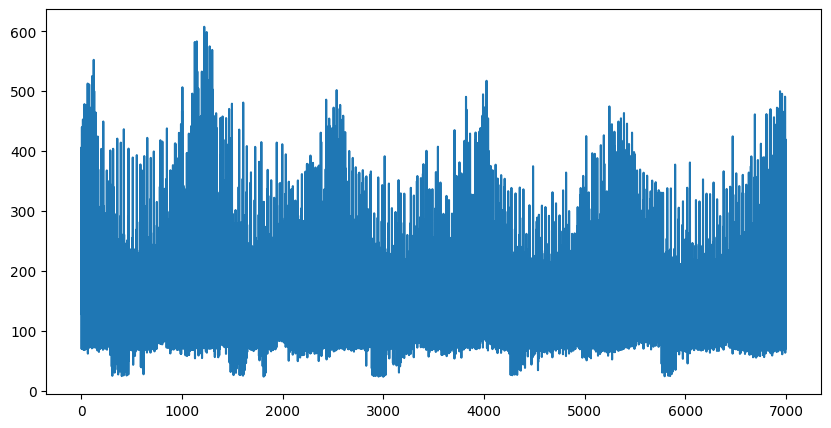

In [29]:
# plot predictions and targets as graph plot
import matplotlib.pyplot as plt


x_values = np.arange(len(predictions))

# Create a plot
plt.figure(figsize=(10, 5))

# Plot the data
plt.plot(x_values, predictions, label='Predictions', linestyle='-')
# plt.plot(x_values, target, label='Targets', linestyle='--')


